# **Disciplina de Introdução à Computação Visual**  
## **Trabalho Prático 2: Compressor JPEG simplificado**

**Aluno:** Kauan Teixeira Pereira

**Matrícula:** 2023087770

Esse notebook python tem por objetivo implementar um pipeline simplificado de compressão de imagens inspirado no padrão JPEG. A entrega do trabalho conta também com um video tratando das decisões tomadas por mim durante seu desenvolvimento ([link para o vídeo](https://exemplo.com)).

**O que será implementado:**
1. Conversão de cor
2. Divisão em blocos
3. Transformada Discreta do Cosseno 
4. Quantização
5. Codificação 
6. Decodificação, desquantização, IDCT e reconstrução
7. Cálculo das métricas: Taxa de compressão e PSNR

---


## Instruções para execução

### 1. Criar e ativar um ambiente virtual

No terminal (Linux, macOS ou WSL):

```bash
# Criar ambiente
python3 -m venv venv

# Ativar ambiente
source venv/bin/activate
```

Se estiver no **Windows (cmd ou PowerShell)**:

```bash
python -m venv venv
venv\Scripts\activate
```

### 2. Instalar as dependências necessárias

Crie um arquivo `requirements.txt` (ou instale direto no terminal):

```bash
pip install numpy opencv-python scipy matplotlib jupyter
```

### 3. Iniciar o Jupyter Notebook

Execute dentro do ambiente virtual:

```bash
jupyter notebook
```

O navegador abrirá automaticamente. Basta navegar até o arquivo `KauanTeixeiraPereira-2023087770.ipynb` e executar as células na sequência.

### 4. Testar para uma imagem 

Ao iniciar a execução, o programa deve realizar o download de uma imagem de nome `input_image.png`.

Caso deseje utilizar uma imagem personalizada, basta adicioná-la na mesma pasta e editar a variável:

```python
IMAGE_PATH = 'input_image.png'
```
Você pode encontrá-la na primeira célula dentro do tópico "Exemplo de execução e cálculo de métricas".

## Imports e funções utilitárias


[descricao]

In [1]:

import numpy as np
import cv2
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt
import math
from typing import Tuple
import pickle
import os
import urllib.request # Apenas para download inicial da imagem


In [2]:
# IMAGE_URL = "https://exemplo.com/sua_imagem.png"
# IMAGE_PATH = "input_image.png"

# if not os.path.exists(IMAGE_PATH):
#     print("Baixando imagem inicial...")
#     urllib.request.urlretrieve(IMAGE_URL, IMAGE_PATH)
#     print("Download concluído.")
# else:
#     print("Imagem já existe:", IMAGE_PATH)

In [3]:
# Não especificamos cores ao criar plots (seguindo as diretrizes do ambiente).
%matplotlib inline

def show_image(img: np.ndarray, title: str = '', figsize=(6,6)):
    plt.figure(figsize=figsize)
    # cv2 uses BGR for color images; matplotlib expects RGB
    if img.ndim == 3 and img.shape[2] == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.title(title)
    plt.axis('off')

def psnr(original: np.ndarray, reconstructed: np.ndarray) -> float:
    mse = np.mean((original.astype(np.float64) - reconstructed.astype(np.float64)) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * math.log10((255.0 ** 2) / mse)

def compression_rate(original_size_bytes: int, compressed_size_bytes: int) -> float:
    return original_size_bytes / compressed_size_bytes

## 1) Conversão de cor

[descricao] RGB → YCbCr e subamostragem 4:2:0

In [4]:

def rgb_to_ycbcr(img_bgr: np.ndarray) -> np.ndarray:
    img = img_bgr.astype(np.float32)
    M = np.array([[ 0.299,  0.587,  0.114],
                  [-0.168736, -0.331264,  0.5],
                  [ 0.5, -0.418688, -0.081312]], dtype=np.float32)
    offset = np.array([0, 128, 128], dtype=np.float32)
    h, w, _ = img.shape
    flat = img.reshape(-1, 3)
    ycbcr = flat.dot(M.T) + offset
    return ycbcr.reshape(h, w, 3)

def ycbcr_to_bgr(ycbcr: np.ndarray) -> np.ndarray:
    M_inv = np.array([[1.0, 0.0, 1.402],
                      [1.0, -0.344136, -0.714136],
                      [1.0, 1.772, 0.0]], dtype=np.float32)
    offset = np.array([0, 128, 128], dtype=np.float32)
    h, w, _ = ycbcr.shape
    flat = (ycbcr - offset).reshape(-1, 3)
    bgr = flat.dot(M_inv.T)
    bgr = np.clip(bgr, 0, 255)
    return bgr.reshape(h, w, 3).astype(np.uint8)

def subsample_420(component: np.ndarray) -> np.ndarray:
    return component.reshape(component.shape[0]//2, 2, component.shape[1]//2, 2).mean(axis=(1,3))

def upsample_420(component_sub: np.ndarray) -> np.ndarray:
    return component_sub.repeat(2, axis=0).repeat(2, axis=1)


## 2) Divisão em blocos

[descricao] em blocos 8×8

In [5]:
def pad_image(channel: np.ndarray, block_size: int = 8) -> Tuple[np.ndarray, Tuple[int,int]]:
    h, w = channel.shape
    pad_h = (block_size - (h % block_size)) % block_size
    pad_w = (block_size - (w % block_size)) % block_size
    padded = np.pad(channel, ((0,pad_h),(0,pad_w)), mode='edge')
    return padded, (h, w)

def block_split(channel: np.ndarray, block_size: int = 8) -> np.ndarray:
    padded, (orig_h, orig_w) = pad_image(channel, block_size)
    H, W = padded.shape
    blocks = padded.reshape(H//block_size, block_size, W//block_size, block_size)
    blocks = blocks.transpose(0,2,1,3).reshape(-1, block_size, block_size)
    return blocks, padded.shape

def block_merge(blocks: np.ndarray, padded_shape: Tuple[int,int], block_size: int = 8, orig_shape: Tuple[int,int]=None) -> np.ndarray:
    h_p, w_p = padded_shape
    H_blocks = h_p // block_size
    W_blocks = w_p // block_size
    arr = blocks.reshape(H_blocks, W_blocks, block_size, block_size).transpose(0,2,1,3).reshape(h_p, w_p)
    if orig_shape is not None:
        orig_h, orig_w = orig_shape
        return arr[:orig_h, :orig_w]
    return arr

## 3) Funções DCT/IDCT

Implementação da transformada direta DCT2 (Discrete Cosine Transform 2D) e da sua inversa IDCT2 usando funções importadas da b iublioteca `scipy.fftpack.dct`.

In [6]:
def dct2(block: np.ndarray) -> np.ndarray:
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block: np.ndarray) -> np.ndarray:
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

## 4) Quantização e matrizes padrão 


[descricao] com matrizes padrão JPEG (luminância e crominância) e fator de qualidade ajustável

In [7]:

Q_Y = np.array([
    [16,11,10,16,24,40,51,61],
    [12,12,14,19,26,58,60,55],
    [14,13,16,24,40,57,69,56],
    [14,17,22,29,51,87,80,62],
    [18,22,37,56,68,109,103,77],
    [24,35,55,64,81,104,113,92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,103,99],
], dtype=np.float32)

Q_C = np.array([
    [17,18,24,47,99,99,99,99],
    [18,21,26,66,99,99,99,99],
    [24,26,56,99,99,99,99,99],
    [47,66,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99],
], dtype=np.float32)

def scaled_quant_matrix(Q: np.ndarray, quality: int) -> np.ndarray:
    if quality < 1: quality = 1
    if quality > 100: quality = 100
    if quality < 50:
        scale = 5000 / quality
    else:
        scale = 200 - 2 * quality
    S = np.floor((Q * scale + 50) / 100)
    S[S==0] = 1
    return S

def quantize_block(block: np.ndarray, Qm: np.ndarray) -> np.ndarray:
    return np.round(block / Qm).astype(np.int32)

def dequantize_block(block_q: np.ndarray, Qm: np.ndarray) -> np.ndarray:
    return (block_q.astype(np.float32) * Qm)


## 5) Codificação Simples

[descricao] Zig-zag scan e RLE (codificação simples)

simples com RLE e salvamento em arquivo binário personalizado

In [8]:

zigzag_index = [
 0, 1, 5, 6,14,15,27,28,
 2, 4, 7,13,16,26,29,42,
 3, 8,12,17,25,30,41,43,
 9,11,18,24,31,40,44,53,
10,19,23,32,39,45,52,54,
20,22,33,38,46,51,55,60,
21,34,37,47,50,56,59,61,
35,36,48,49,57,58,62,63
]

def zigzag_scan(block: np.ndarray) -> np.ndarray:
    flat = block.flatten()
    return flat[zigzag_index]

def inverse_zigzag(arr: np.ndarray) -> np.ndarray:
    block = np.zeros(64, dtype=arr.dtype)
    block[zigzag_index] = arr
    return block.reshape(8,8)

def rle_encode(arr: np.ndarray):
    res = []
    zero_count = 0
    for v in arr[1:]:
        if v == 0:
            zero_count += 1
        else:
            res.append((zero_count, int(v)))
            zero_count = 0
    if zero_count > 0:
        res.append((0,0))
    return res

def rle_decode(rle, dc_value: int):
    arr = [dc_value]
    for zc, val in rle:
        if (zc, val) == (0,0):
            arr.extend([0] * (64 - len(arr)))
            break
        arr.extend([0]*zc)
        arr.append(val)
    while len(arr) < 64:
        arr.append(0)
    return np.array(arr, dtype=np.int32)


## Pipeline de codificação 

Definidos os métodos, escrevemos a pipeline de execução, recebidas as imagens. Seguimos a sequência: DCT → Quantização → RLE.

In [9]:

def encode_component(component: np.ndarray, Qm: np.ndarray, block_size: int = 8):
    blocks, padded_shape = block_split(component, block_size)
    encoded_blocks = []
    dc_prev = 0
    orig_shape = component.shape
    for b in blocks:
        b_shift = b - 128.0
        B = dct2(b_shift)
        Bq = quantize_block(B, Qm)
        zz = zigzag_scan(Bq.astype(np.int32))
        dc = int(zz[0])
        rle = rle_encode(zz)
        encoded_blocks.append((dc - dc_prev, rle))
        dc_prev = dc
    return {
        'encoded_blocks': encoded_blocks,
        'padded_shape': padded_shape,
        'orig_shape': orig_shape,
        'block_size': block_size
    }


## Extra: Salvando arquivo comprimido 

[descricao] (binário simples com pickle) é realmente extra?

In [10]:

def save_compressed(filename: str, data: dict):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

def load_compressed(filename: str) -> dict:
    with open(filename, 'rb') as f:
        return pickle.load(f)


## 6) Decodificação e reconstrução 


[descricao] (IDCT, upsample, conversão para RGB)

In [11]:

def decode_component(encoded: dict, Qm: np.ndarray):
    encoded_blocks = encoded['encoded_blocks']
    padded_shape = encoded['padded_shape']
    orig_shape = encoded['orig_shape']
    block_size = encoded['block_size']

    blocks = []
    dc_prev = 0
    for diff, rle in encoded_blocks:
        dc = dc_prev + diff
        zz = rle_decode(rle, dc)
        Bq = inverse_zigzag(zz).astype(np.int32)
        B = dequantize_block(Bq, Qm)
        b_rec = idct2(B) + 128.0
        blocks.append(np.clip(np.round(b_rec), 0, 255).astype(np.uint8))
        dc_prev = dc
    blocks = np.stack(blocks, axis=0)
    recon = block_merge(blocks, padded_shape, block_size, orig_shape)
    return recon


## Função completa de compressão e descompressão

In [12]:

def compress_image(img_bgr: np.ndarray, quality: int = 75, subsample_420_flag: bool = True):
    h, w, _ = img_bgr.shape
    ycbcr = rgb_to_ycbcr(img_bgr)
    Y = ycbcr[:,:,0]
    Cb = ycbcr[:,:,1]
    Cr = ycbcr[:,:,2]

    if subsample_420_flag:
        Cb_sub = subsample_420(Cb)
        Cr_sub = subsample_420(Cr)
    else:
        Cb_sub = Cb.copy()
        Cr_sub = Cr.copy()

    QY = scaled_quant_matrix(Q_Y, quality)
    QC = scaled_quant_matrix(Q_C, quality)

    enc_Y = encode_component(Y, QY)
    enc_Cb = encode_component(Cb_sub, QC)
    enc_Cr = encode_component(Cr_sub, QC)

    data = {
        'height': h,
        'width': w,
        'quality': quality,
        'subsample_420': subsample_420_flag,
        'QY': QY,
        'QC': QC,
        'enc_Y': enc_Y,
        'enc_Cb': enc_Cb,
        'enc_Cr': enc_Cr
    }
    return data

def decompress_image(data: dict) -> np.ndarray:
    h = data['height']
    w = data['width']
    subsample_420_flag = data['subsample_420']

    Y = decode_component(data['enc_Y'], data['QY'])
    Cb_sub = decode_component(data['enc_Cb'], data['QC'])
    Cr_sub = decode_component(data['enc_Cr'], data['QC'])

    if subsample_420_flag:
        Cb = upsample_420(Cb_sub)[:h, :w]
        Cr = upsample_420(Cr_sub)[:h, :w]
    else:
        Cb = Cb_sub[:h, :w]
        Cr = Cr_sub[:h, :w]

    ycbcr = np.stack([Y[:h, :w], Cb, Cr], axis=2).astype(np.float32)
    bgr = ycbcr_to_bgr(ycbcr)
    return bgr


## Exemplo de execução e cálculo de métricas

In [ ]:
# Parâmetros — altere o caminho da imagem para testar
IMAGE_PATH = 'input_image.png'  # <-- coloque sua imagem aqui
COMPRESSED_FILE = 'compressed_jpeg_like.bin'
QUALITY = 50
SUBSAMPLE = True

# Cria pastas organizadas
os.makedirs("bins", exist_ok=True)
os.makedirs("reconstructed", exist_ok=True)

# Caminhos completos dos arquivos de saída
compressed_path = os.path.join('bins', COMPRESSED_FILE)
reconstructed_path = os.path.join('reconstructed', 'reconstructed_image.jpg')

# Leitura
img = cv2.imread(IMAGE_PATH)
if img is None:
    print(f'Imagem não encontrada em {IMAGE_PATH}. Altere a variável IMAGE_PATH para apontar para um arquivo válido.')
else:
    # Converte BGR → RGB para exibição
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # --- Compressão ---
    data = compress_image(img, quality=QUALITY, subsample_420_flag=SUBSAMPLE)
    save_compressed(compressed_path, data)

    # Tamanho do arquivo original
    try:
        original_size = os.path.getsize(IMAGE_PATH)
    except Exception:
        original_size = img.size

    # Tamanho comprimido
    compressed_size = os.path.getsize(compressed_path)
    rate = compression_rate(original_size, compressed_size)

    # --- Descompressão ---
    rec = decompress_image(data)
    psnr_value = psnr(img, rec)

    rec_rgb = cv2.cvtColor(rec, cv2.COLOR_BGR2RGB)

    print(f'Original size (bytes): {original_size}')
    print(f'Compressed file size (bytes): {compressed_size}')
    print(f'Approx. compression rate: {rate:.2f}x')
    print(f'PSNR: {psnr_value:.2f} dB')

    # Salva imagem reconstruída
    cv2.imwrite(reconstructed_path, rec)
    print(f'Arquivo .bin salvo em: {compressed_path}')
    print(f'Imagem reconstruída salva em: {reconstructed_path}')



Original size (bytes): 1694494
Compressed file size (bytes): 1509907
Approx. compression rate: 1.12x
PSNR: 30.63 dB
Arquivo .bin salvo em: ./compressed_jpeg_like.bin
Imagem reconstruída salva em: ./reconstructed_image.jpg


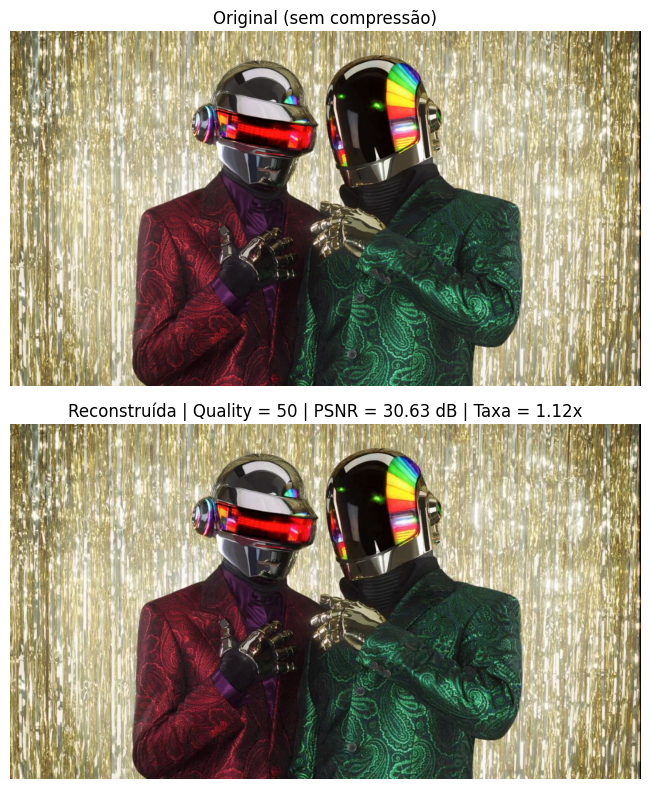

In [14]:
# --- EXIBIR AS DUAS IMAGENS COMO NO SEGUNDO CÓDIGO ---
plt.figure(figsize=(12, 8))

# Original
plt.subplot(2, 1, 1)
plt.imshow(img_rgb)
plt.title('Original (sem compressão)')
plt.axis('off')

# Reconstruída
plt.subplot(2, 1, 2)
plt.imshow(rec_rgb)
plt.title(f'Reconstruída | Quality = {QUALITY} | PSNR = {psnr_value:.2f} dB | Taxa = {rate:.2f}x')
plt.axis('off')

plt.tight_layout()
plt.show()

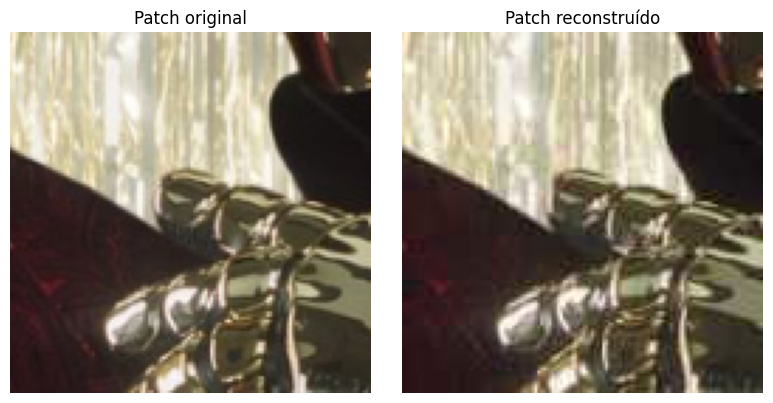

In [15]:
h, w = img.shape[:2]
patch_size = 128
cy, cx = h//2, w//2

y0 = cy - patch_size//2
x0 = cx - patch_size//2

patch_orig = img_rgb[y0:y0+patch_size, x0:x0+patch_size]
patch_rec  = rec_rgb[y0:y0+patch_size, x0:x0+patch_size]

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(patch_orig); plt.title("Patch original"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(patch_rec);  plt.title("Patch reconstruído"); plt.axis("off")
plt.tight_layout()
plt.show()


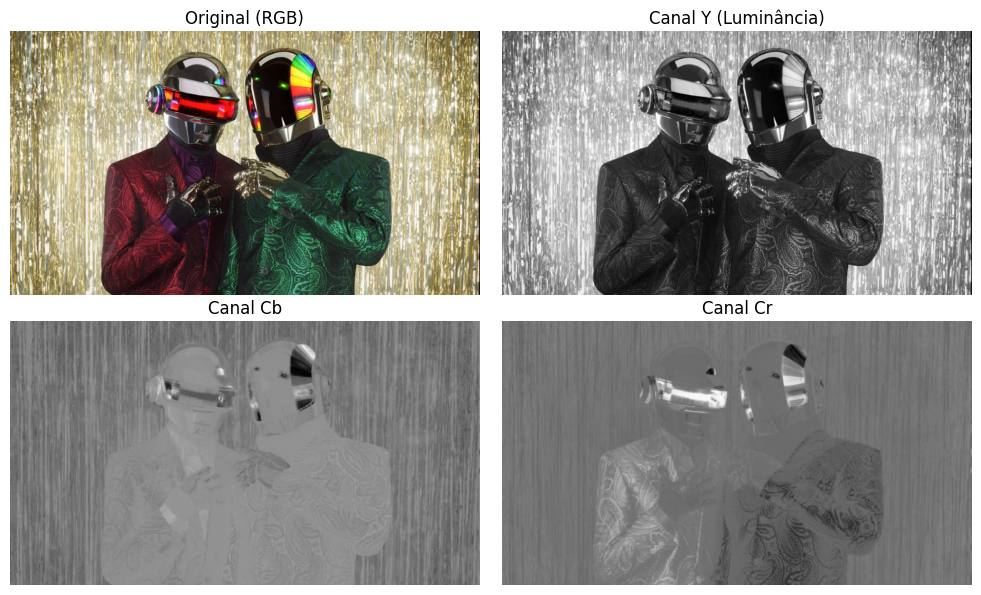

In [16]:
def split_ycrcb(bgr_img):
    # Converte BGR → YCrCb
    ycrcb = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2YCrCb)
    Y, Cr, Cb = cv2.split(ycrcb)
    # retorno organizado como Y, Cb, Cr (para exibição)
    return Y, Cb, Cr

# --- Canais Y, Cb, Cr ---
Y, Cb, Cr = split_ycrcb(img)

plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
plt.imshow(img_rgb)
plt.title("Original (RGB)")
plt.axis("off")

plt.subplot(2,2,2)
plt.imshow(Y, cmap="gray")
plt.title("Canal Y (Luminância)")
plt.axis("off")

plt.subplot(2,2,3)
plt.imshow(Cb, cmap="gray")
plt.title("Canal Cb")
plt.axis("off")

plt.subplot(2,2,4)
plt.imshow(Cr, cmap="gray")
plt.title("Canal Cr")
plt.axis("off")

plt.tight_layout()
plt.show()


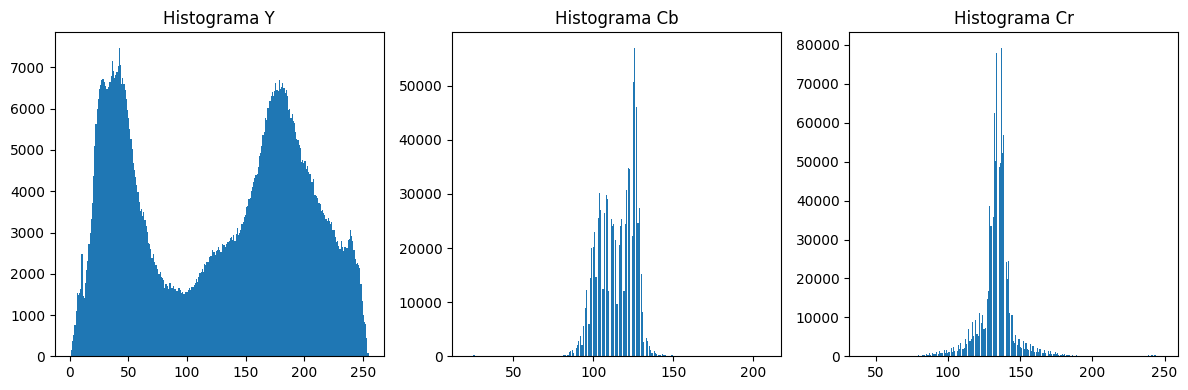

In [17]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.hist(Y.ravel(), bins=256); plt.title("Histograma Y")
plt.subplot(1,3,2); plt.hist(Cb.ravel(), bins=256); plt.title("Histograma Cb")
plt.subplot(1,3,3); plt.hist(Cr.ravel(), bins=256); plt.title("Histograma Cr")
plt.tight_layout()
plt.show()


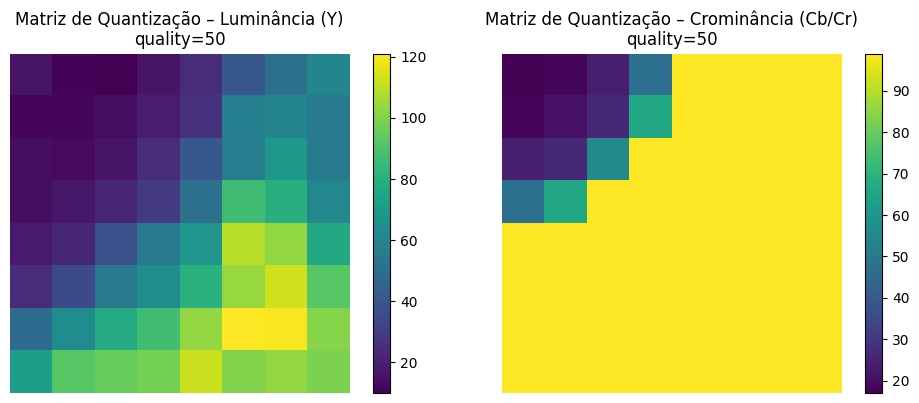

In [18]:
# Gerar matrizes escaladas para qualidade 50 (equivalente ao próprio padrão)
quality = 50
QY_scaled = scaled_quant_matrix(Q_Y, quality)
QC_scaled = scaled_quant_matrix(Q_C, quality)

# Plot
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(QY_scaled, cmap='viridis')
plt.colorbar()
plt.title(f'Matriz de Quantização – Luminância (Y)\nquality={quality}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(QC_scaled, cmap='viridis')
plt.colorbar()
plt.title(f'Matriz de Quantização – Crominância (Cb/Cr)\nquality={quality}')
plt.axis('off')

plt.tight_layout()
plt.show()


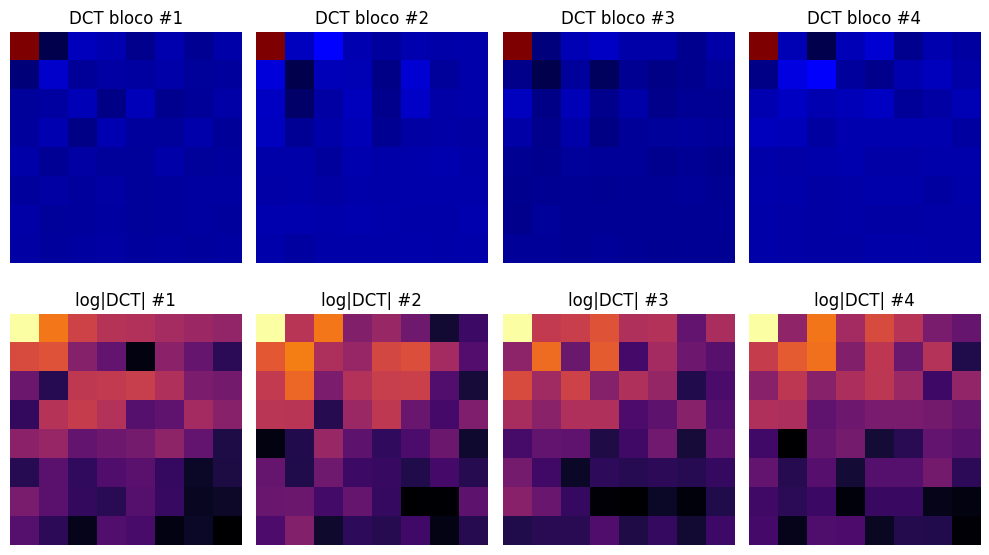

In [19]:
# 1. Quebra em blocos
Yf = Y.astype(np.float32)
blocks, padded_shape = block_split(Yf, block_size=8)

# 2. Aplica DCT nos blocos
dct_blocks = np.array([dct2(b) for b in blocks])

# 3. Remonta a imagem DCT
dctY = block_merge(dct_blocks, padded_shape, block_size=8)

# blocos (0,0), (0,8), (8,0), (8,8)
coords = [(0,0),(0,8),(8,0),(8,8)]
blocks = [dctY[r:r+8, c:c+8] for r, c in coords]

plt.figure(figsize=(10,6))
for i, blk in enumerate(blocks, 1):
    plt.subplot(2,4,i)
    plt.imshow(blk, cmap='seismic')
    plt.title(f"DCT bloco #{i}")
    plt.axis("off")

    plt.subplot(2,4,i+4)
    plt.imshow(np.log1p(np.abs(blk)), cmap="inferno")
    plt.title(f"log|DCT| #{i}")
    plt.axis("off")

plt.tight_layout()
plt.show()


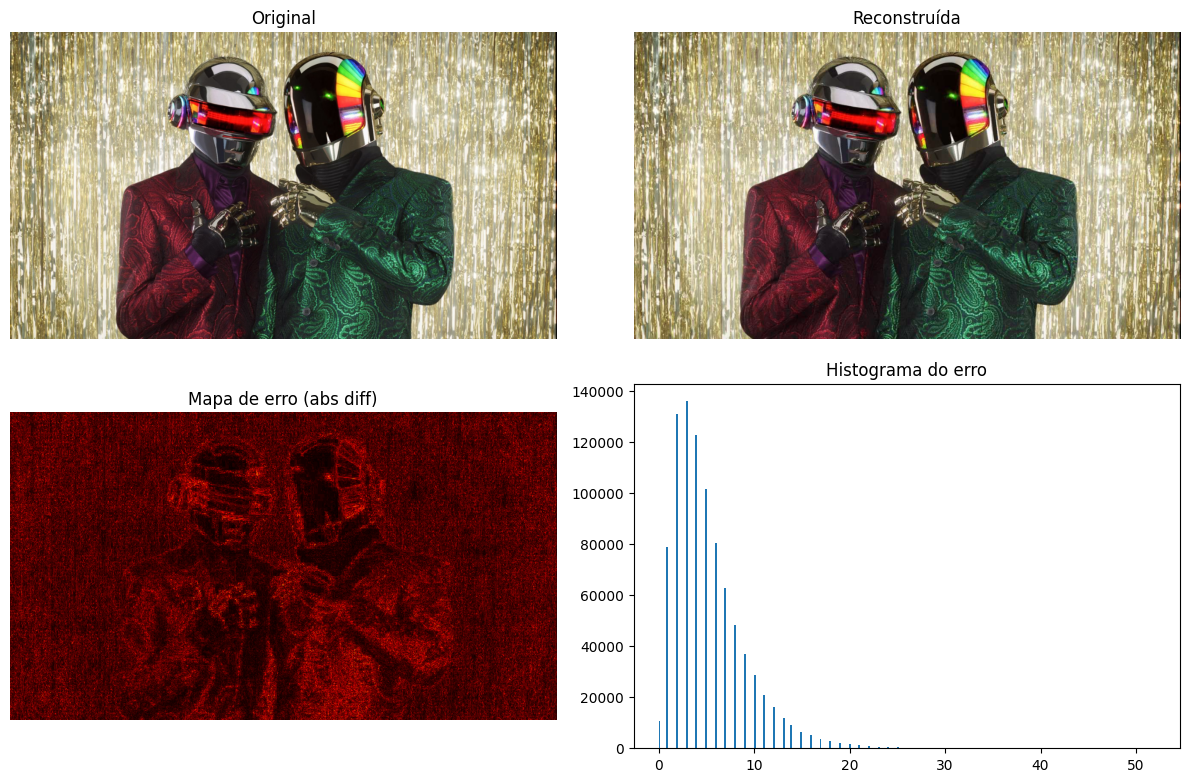

In [20]:
diff = cv2.absdiff(img.astype(np.int16), rec.astype(np.int16)).astype(np.uint8)
diff_gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.imshow(img_rgb)
plt.title("Original")
plt.axis("off")

plt.subplot(2,2,2)
plt.imshow(rec_rgb)
plt.title("Reconstruída")
plt.axis("off")

plt.subplot(2,2,3)
plt.imshow(diff_gray, cmap='hot')
plt.title("Mapa de erro (abs diff)")
plt.axis("off")

plt.subplot(2,2,4)
plt.hist(diff_gray.ravel(), bins=256)
plt.title("Histograma do erro")

plt.tight_layout()
plt.show()


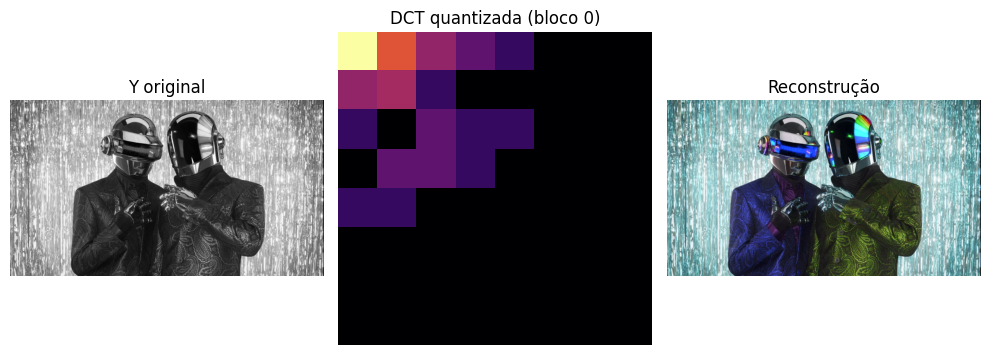

In [21]:
# 1. Separar Y em blocos
Yf = Y.astype(np.float32)
blocks, padded_shape = block_split(Yf, block_size=8)

# 2. DCT em cada bloco
dct_blocks = np.array([dct2(b) for b in blocks])

# 3. Quantização por bloco
Qmat = scaled_quant_matrix(Q_Y, QUALITY)

q_blocks = np.array([quantize_block(b, Qmat) for b in dct_blocks])

# 4. Dequantização
deq_blocks = np.array([dequantize_block(b, Qmat) for b in q_blocks])

# 5. Aplicar IDCT por bloco
rec_blocks = np.array([idct2(b) for b in deq_blocks])

# 6. Reconstruir a imagem Y
recY = block_merge(rec_blocks, padded_shape, block_size=8, orig_shape=Y.shape)
recY = np.clip(recY, 0, 255).astype(np.uint8)

# 7. Recombinar Cb/Cr
ycrcb_recon = cv2.merge([recY, Cb, Cr])
approx_rgb = cv2.cvtColor(ycrcb_recon, cv2.COLOR_YCrCb2RGB)

# 8. Visualização
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1); plt.imshow(Y, cmap="gray"); plt.title("Y original"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(np.log1p(np.abs(q_blocks[0])), cmap="inferno"); plt.title("DCT quantizada (bloco 0)"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(approx_rgb); plt.title("Reconstrução"); plt.axis("off")
plt.tight_layout()
plt.show()


##


=== Processando qualidade 1 ===
Quality=1: compressed=207054 bytes, rate=8.18x, PSNR=15.66 dB
Arquivo bin salvo em: bins/compressed_q1.bin
Imagem reconstruída salva em: reconstructed/reconstructed_q1.jpg

=== Processando qualidade 3 ===
Quality=3: compressed=288736 bytes, rate=5.87x, PSNR=20.06 dB
Arquivo bin salvo em: bins/compressed_q3.bin
Imagem reconstruída salva em: reconstructed/reconstructed_q3.jpg

=== Processando qualidade 5 ===
Quality=5: compressed=374653 bytes, rate=4.52x, PSNR=22.61 dB
Arquivo bin salvo em: bins/compressed_q5.bin
Imagem reconstruída salva em: reconstructed/reconstructed_q5.jpg

=== Processando qualidade 10 ===
Quality=10: compressed=567763 bytes, rate=2.98x, PSNR=25.46 dB
Arquivo bin salvo em: bins/compressed_q10.bin
Imagem reconstruída salva em: reconstructed/reconstructed_q10.jpg

=== Processando qualidade 30 ===
Quality=30: compressed=1131806 bytes, rate=1.50x, PSNR=29.03 dB
Arquivo bin salvo em: bins/compressed_q30.bin
Imagem reconstruída salva em: re

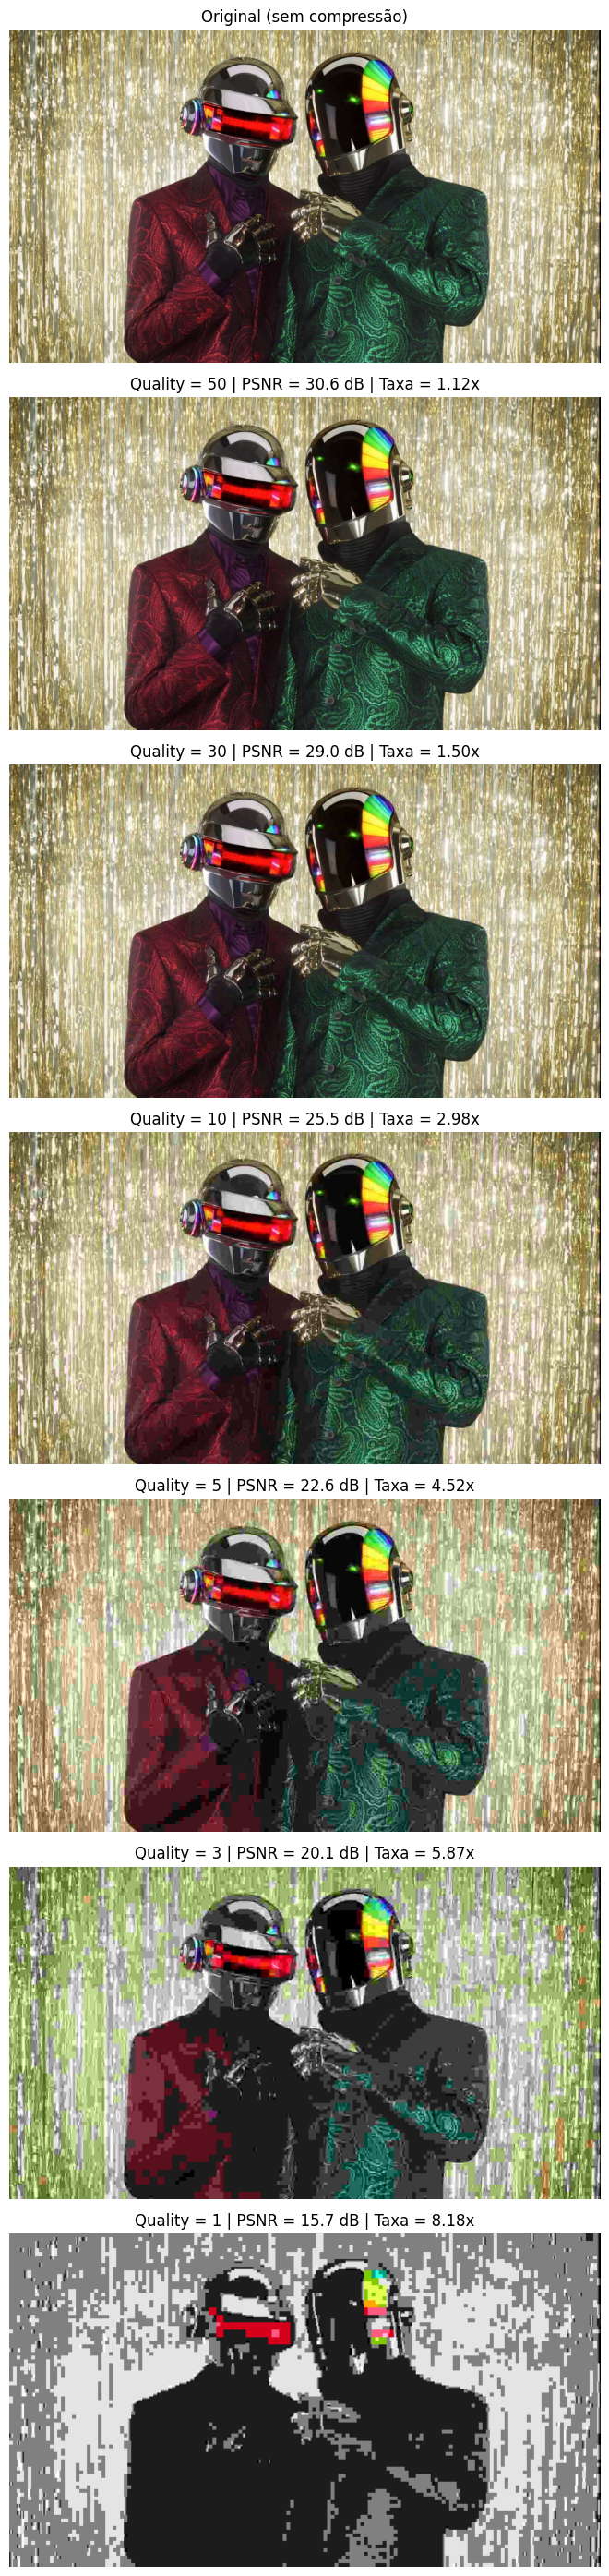

In [22]:
import os
import cv2
import matplotlib.pyplot as plt

# Parâmetros
QUALITIES = [1, 3, 5, 10, 30, 50]  # diferentes níveis de qualidade

# Cria pastas organizadas
os.makedirs("bins", exist_ok=True)
os.makedirs("reconstructed", exist_ok=True)

# Leitura
img = cv2.imread(IMAGE_PATH)
if img is None:
    print(f'Imagem não encontrada em {IMAGE_PATH}. Altere a variável IMAGE_PATH para apontar para um arquivo válido.')
else:
    # Converte BGR -> RGB para exibição
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Tamanho original
    try:
        original_size = os.path.getsize(IMAGE_PATH)
    except Exception:
        original_size = img.size

    results = []

    # --- Loop sobre qualidades ---
    for q in QUALITIES:
        print(f'\n=== Processando qualidade {q} ===')

        # Compressão
        data = compress_image(img, quality=q, subsample_420_flag=SUBSAMPLE)

        # Caminho dos arquivos .bin
        bin_path = os.path.join("bins", f'compressed_q{q}.bin')
        save_compressed(bin_path, data)

        compressed_size = os.path.getsize(bin_path)
        rate = compression_rate(original_size, compressed_size)

        # Descompressão
        rec = decompress_image(data)
        psnr_value = psnr(img, rec)

        # Caminho das imagens reconstruídas
        img_path = os.path.join("reconstructed", f'reconstructed_q{q}.jpg')
        cv2.imwrite(img_path, rec)

        print(f'Quality={q}: compressed={compressed_size} bytes, rate={rate:.2f}x, PSNR={psnr_value:.2f} dB')
        print(f'Arquivo bin salvo em: {bin_path}')
        print(f'Imagem reconstruída salva em: {img_path}')

        # Conversão p/ exibir
        rec_rgb = cv2.cvtColor(rec, cv2.COLOR_BGR2RGB)
        results.append((q, rec_rgb, psnr_value, rate))

    # Ordena do maior Q para o menor Q
    results.sort(key=lambda x: x[0], reverse=True)

    # Visualização
    n = len(results)
    plt.figure(figsize=(12, 4 * (n + 1)))

    # Imagem original
    plt.subplot(n + 1, 1, 1)
    plt.imshow(img_rgb)
    plt.title('Original (sem compressão)')
    plt.axis('off')

    # Reconstruções
    for i, (q, rec_rgb, psnr_val, rate) in enumerate(results):
        plt.subplot(n + 1, 1, i + 2)
        plt.imshow(rec_rgb)
        plt.title(f'Quality = {q} | PSNR = {psnr_val:.1f} dB | Taxa = {rate:.2f}x')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
